In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d

/home/users/yandanw/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning:

Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function



In [2]:
func_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_299/func_0/'

In [10]:
###########################
### PREP VISUAL STIMULI ###
###########################

vision_path = os.path.join(func_path, 'visual')
### Load Photodiode ###
t, ft_triggers, pd1, pd2 = brainsss.load_photodiode(vision_path)
stimulus_start_times = brainsss.extract_stim_times_from_pd(pd2, t)
### Unifrom the units and Make then intigers ###
stimulus_start_times = (stimulus_start_times*100).astype('int') #index needs to be an integers


####################
### Prep Fictrac ###
####################

fictrac_path = os.path.join(func_path, 'fictrac')
fictrac_raw = brainsss.load_fictrac(fictrac_path)


timestamps = brainsss.load_timestamps(os.path.join(func_path, 'imaging'))
fixed = brainsss.load_fda_meanbrain()


### GET 3384 RESOLUTION BEHAVIOR ###

fps = 100
resolution = 10 #desired resolution in ms
expt_len = fictrac_raw.shape[0]/fps*1000
behaviors = ['dRotLabY', 'dRotLabZ', 'heading']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    elif behavior == 'heading': short = 'h'
    fictrac[short] = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior, timestamps[:,20])
    #fictrac[short] = np.roll(fictrac[short],400) # <------- misalignment is corrected !!!!!!
fictrac_timestamps = np.arange(0,expt_len,resolution)

corrs = []
behavior = 'dRotLabY'
for z in range(49):
    fictrac_trace = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior, timestamps[:,z])
    fictrac_trace_L = np.clip(fictrac_trace.flatten(),None,0)*-1 #only needed for Z that has +-.
    # shifted_beh = np.roll(fictrac['Y'][:,0],8) # mismatch of the time
    for voxel in range(2000):
        corrs.append(scipy.stats.pearsonr(all_signals[z,voxel,:], fictrac_trace.flatten())[0])

loading photodiode data... done
Trying to load timestamp data from hdf5 file.
Success.


In [13]:
len(corrs)

98000

In [5]:
atlas = brainsss.load_roi_atlas()

explosion_rois = brainsss.load_explosion_groups()
all_rois = brainsss.unnest_roi_groups(explosion_rois)
roi_masks = brainsss.make_single_roi_masks(all_rois, atlas)
roi_contours = brainsss.make_single_roi_contours(roi_masks, atlas)

In [6]:
n_clusters = 2000
cluster_dir = os.path.join(func_path, 'clustering')

load_file = os.path.join(cluster_dir, 'cluster_labels.npy')
cluster_labels = np.load(load_file)

load_file = os.path.join(cluster_dir, 'cluster_signals.npy')
all_signals = np.load(load_file)

In [7]:
cluster_labels.shape

(49, 32768)

In [8]:
all_signals.shape

(49, 2000, 3384)

In [9]:
def supervoxel_to_full_res(brain, cluster_labels):
    n_clusters = brain.shape[1]
    
    reformed_brain = []
    for z in range(49):
        colored_by_betas = np.zeros((256*128))
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_labels[z,:]==cluster_num)[0]
            colored_by_betas[cluster_indicies] = brain[z,cluster_num]
        colored_by_betas = colored_by_betas.reshape(256,128)
        reformed_brain.append(colored_by_betas)
    return np.asarray(reformed_brain)

In [14]:
whole_corr = np.reshape(np.asarray(corrs),(49,2000))

In [15]:
whole_corr_reformed = supervoxel_to_full_res(whole_corr, cluster_labels)

In [19]:
np.shape(whole_corr)

(49, 2000)

In [17]:
STA_brain = np.swapaxes(whole_corr_reformed[np.newaxis,:,:,:],0,1)

In [18]:
STA_brain.shape

(49, 1, 256, 128)

In [ ]:
#corrs shape is (49*2000=98000)
whole_corr = np.reshape(np.asarray(corrs),(49,2000))
#(49, 2000)
whole_corr_reformed = supervoxel_to_full_res(whole_corr, cluster_labels)
#(49, 256, 128)
STA_brain = np.swapaxes(whole_corr_reformed[np.newaxis,:,:,:],0,1)
#(49, 1, 256, 128)
# STA_brain.shape
warps_ZPOS = brainsss.warp_STA_brain(STA_brain=STA_brain, fly='fly_299', fixed=fixed, anat_to_mean_type='myr')
#(1, 314, 146, 91)

In [21]:
warps_ZPOS = brainsss.warp_STA_brain(STA_brain=STA_brain, fly='fly_299', fixed=fixed, anat_to_mean_type='myr')

In [22]:
np.shape(warps_ZPOS)

(1, 314, 146, 91)

In [25]:
#plt.imshow(cluster_labels[20,:])

In [16]:
input_canvas = np.zeros((500,500,3)) #+.5 #.5 for diverging
data_to_plot = warps_ZPOS[0][:,:,::-1]
vmax = .2
explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                            roi_masks,
                                                            roi_contours,
                                                            data_to_plot,
                                                            input_canvas,
                                                            vmax=vmax,
                                                            cmap='hot',
                                                            diverging=False)#'hot')

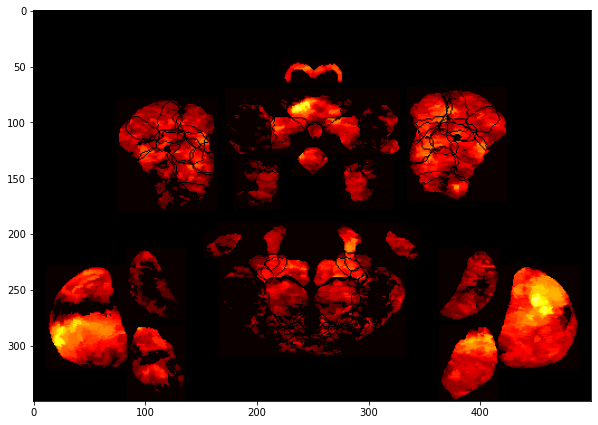

In [17]:
plt.figure(figsize=(10,10))
plt.imshow(explosion_map[150:,:])

In [11]:
fps = 100
resolution = 10 #desired resolution in ms
expt_len = fictrac_raw.shape[0]/fps*1000
timestamps = brainsss.load_timestamps(os.path.join(func_path, 'imaging'))
fixed = brainsss.load_fda_meanbrain()
def make_exp(behavior,
             fly,
             all_signals,
             fps,re):
    ####
    # This function is to explode the brain to make the exploded brain map
    ####
    
    ### variables needed ###

    
    corrs = []
    for z in range(49):
        fictrac_trace = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior, timestamps[:,z])
        # shifted_beh = np.roll(fictrac['Y'][:,0],8) # mismatch of the time
        for voxel in range(2000):
            corrs.append(scipy.stats.pearsonr(all_signals[z,voxel,:], fictrac_trace.flatten())[0])
    
    whole_corr = np.reshape(np.asarray(corrs),(49,2000))
    whole_corr_reformed = supervoxel_to_full_res(whole_corr, cluster_labels)
    STA_brain = np.swapaxes(whole_corr_reformed[np.newaxis,:,:,:],0,1)
    # STA_brain.shape
    warps = brainsss.warp_STA_brain(STA_brain=STA_brain, fly=fly, fixed=fixed, anat_to_mean_type='myr')
    input_canvas = np.zeros((500,500,3)) #+.5 #.5 for diverging
    data_to_plot = warps[0][:,:,::-1]
    vmax = .2
    explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                            roi_masks,
                                                            roi_contours,
                                                            data_to_plot,
                                                            input_canvas,
                                                            vmax=vmax,
                                                            cmap='seismic',
                                                            diverging= True)#'hot')
    plt.figure(figsize=(10,10))
    plt.imshow(explosion_map[150:,:])
    plt.title(f"{behavior} of {fly}")
    
    save_file = os.path.join(func_path,'figs')
    if not os.path.exists(save_file):
        os.mkdir(save_file)
    timestr = time.strftime("%Y%m%d-%H%M%S")
    save_file = os.path.join(save_file,timestr)
    plt.savefig(save_file,dpi=300,bbox_inches='tight')

Trying to load timestamp data from hdf5 file.
Success.


In [ ]:
# save image
# put text title fly and behavior
# confirm on known fly

AttributeError: 'str' object has no attribute 'shape'

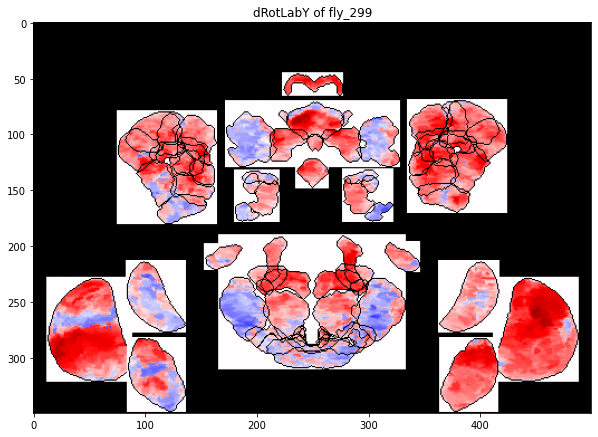

In [13]:
behavior = 'dRotLabY'
fly = "fly_299"

make_exp(behavior, fly, all_signals,fps = 100, re = 10)